# Costa Rican Household Poverty Prediction

Dataset : https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data

# Menyiapkan Akun Kredential Kaggle

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dan Menyiapakan Dataset

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle competitions download -c costa-rican-household-poverty-prediction

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 117MB/s]


In [ ]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip /content/costa-rican-household-poverty-prediction.zip

Archive:  /content/costa-rican-household-poverty-prediction.zip
  inflating: codebook.csv            
  inflating: codebook.xlsx           
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.zip  
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
  inflating: test.csv.zip            
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               
  inflating: train.csv.zip           


# Import Library

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

**DATA CLEANING**

In [ ]:
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


# Soal 1
Lihat apakah ada data yang hilang

In [ ]:
null = train.isnull().sum()
null_df = pd.DataFrame(null, columns=['count'])
null_df[null_df['count']!=0]

,count
v2a1,6860
v18q1,7342
rez_esc,7928
meaneduc,5
SQBmeaned,5


In [ ]:
mean = train.isnull().mean()
mean_df = pd.DataFrame(mean, columns=['mean'])
mean_df[mean_df['mean']!=0]

,mean
v2a1,0.717798
v18q1,0.768233
rez_esc,0.829549
meaneduc,0.000523
SQBmeaned,0.000523


Karena rasio data yang hilang dari rez_esc(Tahun tertinggal di sekolah) dan v18q1(Jumlah tablet dalam rumah tangga) masing-masing adalah 0,82 dan 0,76, kita akan menghapus kolom tersebut.
Kita akan mengurus v2a1 (sewa bulanan) nanti

In [ ]:
train.drop(columns=['v18q1', 'rez_esc'], inplace=True)
test.drop(columns=['v18q1', 'rez_esc'], inplace=True)

Ada dua kolom lagi dengan 5 data yang hilang. meaneduc dan SBQmeaned

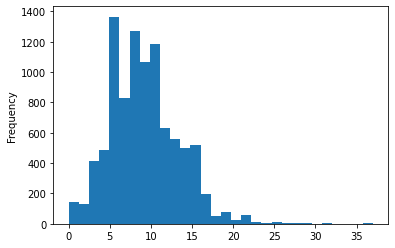

In [ ]:
train['meaneduc'].plot(kind='hist', bins=30)

Karena plotnya adalah kurva guasian yang cukup baik, kita dapat menggunakan mean untuk mengisi nilai yang tersisa

# soal 2 

Lakukan fillna pada data test

In [ ]:
train['meaneduc'].fillna(np.mean(train['meaneduc']), inplace=True)
test['meaneduc'].fillna(np.mean(test['meaneduc']), inplace=True)

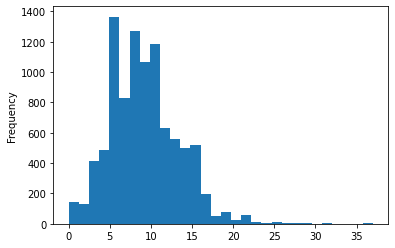

In [ ]:
np.sqrt(train['SQBmeaned']).plot(kind='hist', bins=30)

Jelas akar kuadrat dari kolom SQBmeaned memberi kita plot yang sama persis dengan plot meaneduc. Dengan demikian kita dapat menghapus fitur ini karena bersifat repetatif.

In [ ]:
train.drop(columns=['SQBmeaned'], inplace=True)
test.drop(columns=['SQBmeaned'], inplace=True)

In [ ]:
train['Target'].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

Ada perbedaan antara hasil yang ditargetkan. Mari kita lanjutkan, jika hasilnya tidak sesuai, kita dapat mencoba melakukan oversampling data.

**CLEANING FAMILY MEMBERS DATA**

Kita melihat apakah ada fitur yang berulang atau mirip satu sama lain.

In [ ]:
 train[train['tamviv']!=train['r4t3']].head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,agesq,Target
130,ID_651377e3e,260000.0,0,5,0,1,1,1,1,2,...,7,1,49,16,100,4,4.0,1.0,49,4
131,ID_8296b0e0e,260000.0,0,5,0,1,1,1,1,2,...,33,81,1089,16,100,4,4.0,1.0,1089,4
132,ID_22d324777,260000.0,0,5,0,1,1,1,1,2,...,34,100,1156,16,100,4,4.0,1.0,1156,4
133,ID_272bdf973,260000.0,0,5,0,1,1,1,1,2,...,13,36,169,16,100,4,4.0,1.0,169,4
195,ID_21b09d0df,NaN,0,4,0,1,1,0,0,0,...,7,0,49,16,0,9,9.0,9.0,49,2


Mungkin jumlah anggota yang tinggal di rumah tangga (tamviv) harus lebih banyak daripada semua orang di rumah tangga (r4t3). Mari kita verifikasi sekali saja

# Soal 3
cek korelasi target antara tamviv dan juga r4t3

In [ ]:
corr1 = train.corr()
print(corr1['Target']['tamviv'])
print(corr1['Target']['r4t3'])

-0.1582238549099864
-0.14754827064335066


Seperti yang diharapkan tamviv berkorelasi lebih dari r4t3 (Meskipun perbedaan tipis). Jadi mari kita hapus r4t3 juga.

In [ ]:
 train[train['hhsize']!=train['tamhog']]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,agesq,Target


In [ ]:
 train[train['hogar_total']!=train['tamhog']]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,agesq,Target


Jelas hhsize dan tamhog dan hogar_total adalah fitur yang sama. Kita akan menghapus fitur hhsize dan tamhog

Karena setiap rumah tangga memiliki satu kepala keluarga dan tidak hanya fitur Target tetapi sebagian besar fitur mandiri adalah umum untuk satu rumah tangga. Dari sini kita hanya mengambil kepala rumah tangga (parentesco1) dan menganalisisnya.

In [ ]:
train_select = train.loc[train['parentesco1'] == 1]
test_select = test.loc[test['parentesco1'] == 1]

In [ ]:
train_select.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,0,1,...,43,100,1849,1,100,0,1.000000,0.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,0,1,...,67,144,4489,1,144,0,1.000000,64.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,0,0,...,92,121,8464,1,0,0,0.250000,64.0,8464,4
5,ID_ec05b1a7b,180000.0,0,5,0,1,1,1,0,2,...,38,121,1444,16,121,4,1.777778,1.0,1444,4
8,ID_1284f8aad,130000.0,1,2,0,1,1,0,0,1,...,30,81,900,16,81,4,16.000000,1.0,900,4


In [ ]:
train_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 9552
Columns: 140 entries, Id to Target
dtypes: float64(5), int64(130), object(5)
memory usage: 3.2+ MB


**EXTRA FEATURES**

Ada beberapa kolom yang khusus anggota individu. Kita tidak ingin kehilangan data dengan kode di atas. Beberapa kolom ini adalah:
* disabled
* male
* female
* escolari(No of years of education)

Kita akan membuat 4 fitur baru:
1. mean_edu      : Average education of all family members
2. no.of.males   : Number of males in household
3. no.of.females : Number of females in household
4. disabled      : Number of disabled members in family

In [ ]:
disabled=[]
num_male=[]
num_female=[]
mean_edu=[]
for i in train_select['idhogar']:
    k = train[train['idhogar']== i]['dis'].sum()
    j = train[train['idhogar']== i]['male'].sum()
    p = train[train['idhogar']== i]['female'].sum()
    e = train[train['idhogar']== i]['escolari'].mean()
    disabled.append(k)
    num_male.append(j)
    num_female.append(p)
    mean_edu.append(e)

# For test data
disabledt=[]
num_malet=[]
num_femalet=[]
mean_edut=[]
for i in test_select['idhogar']:
    k = test[test['idhogar']== i]['dis'].sum()
    j = test[test['idhogar']== i]['male'].sum()
    p = test[test['idhogar']== i]['female'].sum()
    e = test[test['idhogar']== i]['escolari'].mean()
    disabledt.append(k)
    num_malet.append(j)
    num_femalet.append(p)
    mean_edut.append(e)
    

In [ ]:
train_select.loc[:,'mean_edu'] = mean_edu
train_select.loc[:,'no.of.males'] = num_male
train_select.loc[:,'no.of.females'] = num_female
train_select.loc[:,'diabled'] = disabled

test_select.loc[:,'mean_edu'] = mean_edut
test_select.loc[:,'no.of.males'] = num_malet
test_select.loc[:,'no.of.females'] = num_femalet
test_select.loc[:,'diabled'] = disabledt

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Karena kita telah menghitung pendidikan rata-rata semua anggota, kita juga menghapus kolom meaneduc. Kolom edjefe/edjefa menunjukkan pendidikan kepala rumah tangga. Tetapi karena kita hanya mengambil baris yang berisi anggota kepala, kolom 'escolari' menunjukkan hal yang sama

Oleh karena itu kita menghapus kolom edjefe/edjefa dan mempertahankan kolom escolari di tempatnya.

Kita melihat bahwa kolom 'dependency' memiliki beberapa ya/tidak di dalamnya. Menurut rumus, ya sesuai dengan 1 dan tidak dengan 0

# Soal 4
Lakukan penggatian yes = 1 dan no = 0 untuk data train dan test yang dipilih

In [ ]:
train_select['dependency'] = train_select['dependency'].replace('yes', '1')
train_select['dependency'] = train_select['dependency'].replace('no', '0')

test_select['dependency'] = test_select['dependency'].replace('yes', '1')
test_select['dependency'] = test_select['dependency'].replace('no', '0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_select['dependency'] = train_select['dependency'].astype(float)
test_select['dependency'] = test_select['dependency'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**RENT FEATURE**

In [ ]:
rr = train_select['v2a1'].isnull().sum()
print('Number of null rows in montly rent column - {}'.format(rr))

Number of null rows in montly rent column - 2156


Ada 5 fitur yang harus diperhatikan sebelum mengisi kolom sewa bulanan
1. tipovivi1 = 1 rumah sendiri dan dibayar penuh
2. tipovivi2 = 1 sendiri, bayar dicicil
3. tipovivi3 = 1 disewa
4. tipovivi4 = 1 genting
5. tipovivi5 =1 lainnya(ditugaskan, dipinjam)

Untuk semua rumah tangga (households) yang dimiliki dan dibayar penuh, kolom sewa bulanan dapat disetel ke nol.

Kita dapat mempertimbangkan untuk membayar dengan mencicil sebagai sewa bulanan.

Kita akan memutuskan sewa rumah genting dan pinjaman sesuai dengan distribusi data

Untuk 5 cuplikan kode berikutnya, kita akan menganalisis kolom sewa bulanan mana yang nol sehubungan dengan fitur tipovivi

In [ ]:
train_select[(train_select['tipovivi1']==1) ]['v2a1'].isnull().sum()

1856

In [ ]:
train_select[(train_select['tipovivi2']==1) ]['v2a1'].isnull().sum()

0

In [ ]:
train_select[(train_select['tipovivi3']==1) ]['v2a1'].isnull().sum()

0

In [ ]:
train_select[(train_select['tipovivi4']==1) ]['v2a1'].isnull().sum()

46

In [ ]:
train_select[(train_select['tipovivi5']==1) ]['v2a1'].isnull().sum()

254

Ada 1856 rumah tangga yang dimiliki dan dengan demikian kita akan menandai kolom v2a1(sewa bulanan) sebagai 0.
Karena distribusi sewa sangat miring, kita akan menggunakan median data dan menetapkan nilai tersebut ke 300 nilai yang tersisa (tipovivi4 dan tipovivi5)

In [ ]:
index = train_select.index
for i in index:
    if train_select['tipovivi1'][i]==1:
        train_select.loc[i, 'v2a1'] = 0

index2 = test_select.index
for i in index2:
    if test_select['tipovivi1'][i]==1:
        test_select.loc[i, 'v2a1'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
median = train_select[(train_select['tipovivi3']==1) | ((train_select['tipovivi2']==1)) ]['v2a1'].median()

mediant = test_select[(test_select['tipovivi3']==1) | ((test_select['tipovivi2']==1)) ]['v2a1'].median()

In [ ]:
for i in train_select.index:
    if train_select['tipovivi4'][i]==1:
        train_select.loc[i, 'v2a1'] = median
        
for i in train_select.index:
    if train_select['tipovivi5'][i]==1:
        train_select.loc[i, 'v2a1'] = median
        
for i in test_select.index:
    if test_select['tipovivi4'][i]==1:
        test_select.loc[i, 'v2a1'] = mediant
        
for i in test_select.index:
    if test_select['tipovivi5'][i]==1:
        test_select.loc[i, 'v2a1'] = mediant

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
train_select['v2a1'].isnull().sum()

0

Grafik di bawah ini adalah plot histogram sewa bulanan

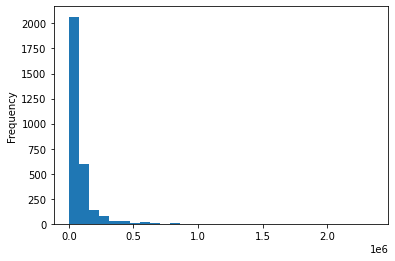

In [ ]:
train_select['v2a1'].plot(kind='hist', bins=30)

Di bawah ini adalah susunan korelasi antara Target dan setiap fitur lainnya

In [ ]:
corr2 = train_select.corr()
corr2['Target']

v2a1             0.118401
hacdor          -0.136275
rooms            0.201019
hacapo          -0.096313
v14a             0.068230
                   ...   
Target           1.000000
mean_edu         0.423626
no.of.males     -0.023473
no.of.females   -0.145422
diabled         -0.115741
Name: Target, Length: 140, dtype: float64

Seiring dengan fitur yang kita hapus seperti yang disebutkan di atas, kita juga menghapus semua kolom SQB karena mereka hanyalah akar kuadrat dari kolom lainnya. Kita akan menghapus instlevel(pendidikan anggota), parentesco(hubungan sebagai anggota keluarga), estadocivil(data pernikahan) karena kita hanya mempertimbangkan data kepala rumah tangga.

In [ ]:
remove_columns=['tamhog', 'r4t3', 'r4h1','r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 'r4t2', 
               'parentesco1', 'parentesco2', 'parentesco3', 'parentesco4', 'parentesco5','parentesco6',
                'parentesco7', 'parentesco8', 'parentesco9', 'parentesco10', 'parentesco11',
               'parentesco12', 'age', 'SQBescolari', 'SQBage', 'SQBhogar_total','SQBhogar_nin',
                'SQBovercrowding', 'SQBdependency', 'agesq', 'edjefa','edjefe' ,'SQBedjefe', 'instlevel1', 
                'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5','instlevel6', 'instlevel7', 
                'instlevel8', 'instlevel9','meaneduc', 'hacdor', 'hacapo', 'estadocivil1', 'estadocivil2',
               'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 'tipovivi1',
               'tipovivi2','tipovivi3','tipovivi4','tipovivi5', 'hhsize', 'dis', 'male', 'female']

In [ ]:
train_select_2 = train_select.drop(columns= remove_columns)
test_select_2 = test_select.drop(columns= remove_columns)

In [ ]:
train_select_2.head()

,Id,v2a1,rooms,v14a,refrig,v18q,tamviv,escolari,paredblolad,paredzocalo,...,lugar4,lugar5,lugar6,area1,area2,Target,mean_edu,no.of.males,no.of.females,diabled
0,ID_279628684,190000.0,3,1,1,0,1,10,1,0,...,0,0,0,1,0,4,10.00,1,0,0
1,ID_f29eb3ddd,135000.0,4,1,1,1,1,12,0,0,...,0,0,0,1,0,4,12.00,1,0,0
2,ID_68de51c94,0.0,8,1,1,0,1,11,0,0,...,0,0,0,1,0,4,11.00,0,1,1
5,ID_ec05b1a7b,180000.0,5,1,1,1,4,11,1,0,...,0,0,0,1,0,4,8.25,2,2,0
8,ID_1284f8aad,130000.0,2,1,1,0,4,9,1,0,...,0,0,0,1,0,4,5.75,1,3,0


In [ ]:
X = train_select_2.drop(columns=['Target', 'idhogar', 'Id'])
y = train_select_2['Target']
X_given = test_select_2.drop(columns=[ 'idhogar', 'Id'])

**TRAINING THE MODEL**

# Soal 5 
Lakukan Training model menggunakan Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

Kita akan menggunakan algoritma Random Forest Classifier. Ini adalah salah satu teknik ensambel dan juga disebut sebagai agregasi bootstrap.

Kita memilih himpunan bagian acak dari baris dan kolom data. Kita memberi makan himpunan bagian ini ke pohon keputusan yang berbeda secara bersamaan. Subset yang kita buat selalu diambil dengan penggantian. Oleh karena itu teknik ini disebut **Row and Column Sampling with replacement**.

Setelah model dilatih, kita memasukkan data uji. Misalkan kita mengklasifikasikan sesuatu, maka output yang diberikan sebagian besar model akan diperhitungkan. Karena kita pertama membagi kemudian merakit kembali, ini disebut **Agregasi bootstrap**

Ada beberapa hyperparameter ketika kita menggunakan Random Forest. Beberapa yang penting adalah :
1. n_estimators    : Number of decision trees we want to use
2. max_depth       : Maximum depth of a decision tree. If None, then nodes are expanded till they are pure
3. max_features    : The maximum features to consider while spliting a node. 
4. min_sample_leaf : The minimum number of samples(row wise different examples) present at the leaf(end node).
5. min_sample_split: The minimum number of samples(row wise different examples) required to be present to split a node.

Untuk mengetahui hyperparameter mana yang terbaik, kita akan menerapkan Pencarian Acak CV. Ini secara acak menginisialisasi hyperparameter yang diberikan dalam kamus dan mengeluarkan parameter terbaik. Meskipun lebih cepat dari Grid Search CV, masih membutuhkan banyak waktu untuk eksekusi.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'n_estimators':[100, 200, 400, 600, 800],
              'max_depth' : [5, 10, 15,20, 30, None],
              'max_features' : ['auto', 'log2'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split' : [2, 5, 10]} 

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, n_jobs = -1)

Teknik lain yang kita gunakan adalah validasi silang K-fold. Misalkan kita menggunakan CV 5 kali lipat, itu berarti bahwa data pelatihan dibagi menjadi 5 bagian. Kita mengambil bagian pertama sebagai tes dan sisanya 4 sebagai dataset train. Kemudian kita mengambil bagian kedua sebagai tes dan sisanya sebagai set pelatihan. Setelah proses selesai, kita mengambil rata-rata dari semua skor. Ini akan menjadi matriks kinerja model.

In [ ]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 30, None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800]},
                   verbose=2)

In [ ]:
rf_random.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [ ]:
pred = rf_random.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(f1_score(y_test, pred, average='macro'))

[[  5  16   0  47]
 [  4  38   1 100]
 [  1  26   2 110]
 [  1  28   2 601]]
              precision    recall  f1-score   support

           1       0.45      0.07      0.13        68
           2       0.35      0.27      0.30       143
           3       0.40      0.01      0.03       139
           4       0.70      0.95      0.81       632

    accuracy                           0.66       982
   macro avg       0.48      0.33      0.32       982
weighted avg       0.59      0.66      0.58       982

0.3159650775690694


Setelah implementasi CV Pencarian Acak, kita menghasilkan parameter terbaik berikut:
1. n_estimators    : 400
2. max_depth       : 30
3. max_features    : auto
4. min_sample_leaf : 1
5. min_sample_split: 2

Untuk membuat kode lebih akurat, kita akan mempersempit pencarian kita dan menggunakan cv pencarian grid yang menghitung akurasi untuk setiap kombinasi.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid = {'n_estimators':[ 470, 480, 490, 400, 510, 520, 530],
              'max_depth' : [25, 30,35, None],
              'max_features' : ['auto', 'log2'],
              'min_samples_leaf': [1, 2],
              'min_samples_split' : [ 2,3]}

In [ ]:
rf = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(estimator = rf, param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [25, 30, 35, None],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [470, 480, 490, 400, 510, 520, 530]},
             verbose=2)

In [ ]:
grid_search.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 510}

In [ ]:
pred =grid_search.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(f1_score(y_test, pred, average='macro'))

[[  7  17   0  44]
 [  5  39   1  98]
 [  2  23   3 111]
 [  1  28   1 602]]
              precision    recall  f1-score   support

           1       0.47      0.10      0.17        68
           2       0.36      0.27      0.31       143
           3       0.60      0.02      0.04       139
           4       0.70      0.95      0.81       632

    accuracy                           0.66       982
   macro avg       0.53      0.34      0.33       982
weighted avg       0.62      0.66      0.58       982

0.33300632320809803


Skor makro f1 sedikit meningkat. Akurasinya sekitar 66%. Kita melihat bahwa kelas 4 telah diprediksi dengan sangat baik. Tetapi kelas lain tidak terlalu akurat. Hal ini mungkin disebabkan oleh fakta bahwa dataset pelatihan memiliki banyak nilai Target yang termasuk dalam kelas 4. Langkah-langkah yang dapat kita ambil untuk meningkatkan akurasi:

1. Teknik oversampling untuk menghindari dominasi satu kelas
2. Kita dapat mencoba mengurangi jumlah fitur lebih lanjut
3. Kita bisa menggunakan algoritma lain seperti Gradient boosting atau Xg boost

Kita sekarang akan menerapkan model ke kumpulan data original test dan menyimpan hasil ke submission file.

In [ ]:
real_pred = grid_search.predict(X_given)

In [ ]:
c=0
for i in test_select['idhogar']:
    test2 = test[test['idhogar'] == i]
    for j in test2.index:
        test.loc[j, 'Target'] = real_pred[c] 
    c=c+1

In [ ]:
submit = pd.DataFrame({'Id': test['Id'], 'Target': test['Target']})

In [ ]:
submit.head()

,Id,Target
0,ID_2f6873615,4.0
1,ID_1c78846d2,4.0
2,ID_e5442cf6a,4.0
3,ID_a8db26a79,4.0
4,ID_a62966799,4.0


In [ ]:
submit.to_csv('submission.csv', index=False)